In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Gradient Descent

Consider a function $f$ from $\mathbb{R}^n$ to $\mathbb{R}$. We want to create an algorithm that starts from some initial point $x_0$ and finds a local minimum of $f$.
The algorithm will work in steps. How should we move at each step? 

## The negative gradient is the direction of steepest descent
From calculus we know that the direction of negative gradient is the direction of steepest descent. Let's try to understand this statement.
Suppose you are standing at $x_0$ and that you are taking a small step of size $\alpha$ in the direction of a unit vector $u$. Then, the new $f$ value will be:

$$f(x_0 + \alpha u) \approx f(x_0) + \alpha \nabla f(x_0) \cdot u.$$

Which $u$ gives us the steepes descent?
Consider the dot product between the gradient and the unit vector $u$:

$$\nabla f(x_0) \cdot u = \|\nabla f(x_0)\| \|u\| \cos \theta = \|\nabla f(x_0)\| \cos \theta.$$

Or:

$$f(x_0 + \alpha u) \approx f(x_0) + \alpha \|\nabla f(x_0)\| \cos \theta.$$

So, we get the minimum value if we make the cosine equal to $-1$, i.e. if we move in the direction of the negative gradient ($\theta = \pi$).

## Gradient descent algorithm (simplest version that doesn't work)

Let's move a small step in the direction of the negative gradient.
The algorithm is:

$$x_{k+1} = x_k - \alpha \nabla f(x_k).$$

The step size $\alpha$ is called the learning rate. It is a hyperparameter that we need to choose. If it is too small, the algorithm will take too long to converge. If it is too large, the algorithm will not converge.

Let's try it out and see if it works. Here is a simple implementation:

In [3]:
import jax.numpy as jnp 
from jax import grad, jit, vmap

def gradient_descent(f, x0, n_iter=10, lr=0.1, return_path=False):
    """Gradient descent"""
    x = x0
    path = []
    for _ in range(n_iter):
        x = x - lr * grad(f)(x)
        path.append(x)
    if return_path:
        return x, path
    return x

Let's try a 1D problem function first:

$$
f(x) = x^4 - 3x^3 + 2.
$$

We will start at $x_0 = 2$.
Let's see what happens:

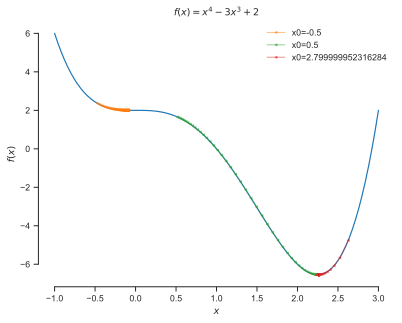

In [4]:
# The function to minimize
f1 = lambda x: x ** 4 - 3 * x ** 3 + 2

# Plot the function
xs = jnp.linspace(-1, 3, 100)
fig, ax = plt.subplots()
ax.plot(xs, f1(xs))
ax.set(xlabel='$x$', ylabel='$f(x)$', title='$f(x) = x^4 - 3x^3 + 2$')

# We will start from three different points:
x0s = jnp.array([-0.5, 0.5, 2.8])

# The learning rate
alpha = 0.01
n_iter = 100

for x0 in x0s:
    x, path = gradient_descent(f1, x0, n_iter=n_iter, lr=alpha, return_path=True)
    f_path = vmap(f1)(jnp.array(path))
    ax.plot(path, f_path, '<-', markersize=2, linewidth=1, alpha=0.5, label=f'x0={x0}')
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

Here is what we notice:
- The algorithm converges to a local minimum when you start close enough to it.
- The algorithm doesn't converge if you start close to the saddle point.

Let's now try a bigger learning rate and see what happens:

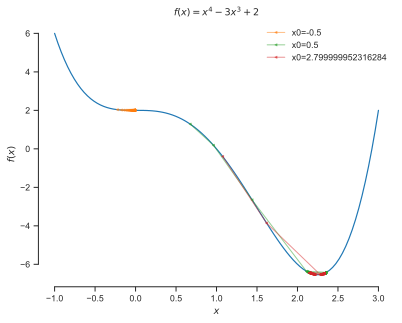

In [7]:
fig, ax = plt.subplots()
ax.plot(xs, f1(xs))
ax.set(xlabel='$x$', ylabel='$f(x)$', title='$f(x) = x^4 - 3x^3 + 2$')

# A bigger learning rate
alpha = 0.1

for x0 in x0s:
    x, path = gradient_descent(f1, x0, n_iter=n_iter, lr=alpha, return_path=True)
    f_path = vmap(f1)(jnp.array(path))
    ax.plot(path, f_path, '<-', markersize=2, linewidth=1, alpha=0.5, label=f'x0={x0}')
ax.legend(loc='best', frameon=False)
sns.despine(trim=True);

Observe that the algorithm oscillates around the minimum.

Let's do the same in 2D.
We are going to need a function to plot the path of the algorithm:

In [8]:
def plot_path(i, x_list):
    plt.quiver(x_list[:-1, 0], x_list[:-1, 1], x_list[1:, 0] - x_list[:-1, 0], x_list[1:, 1] - x_list[:-1, 1], 
               scale_units='xy', angles='xy', scale=1, color=plt.cm.tab10(i), width=0.004, headwidth=3, headlength=4)

Here is the 2D function and the optimization:

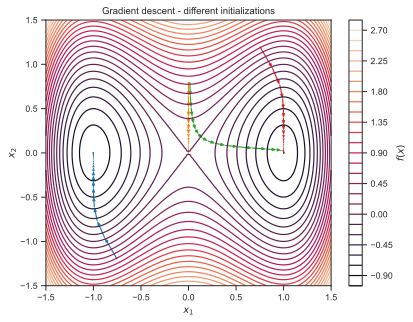

In [11]:
# The function to minimize
f = lambda x: x[0] ** 4 - 2.0 * x[0] ** 2 + x[1] ** 2
vf = vmap(f)
grad_f = jit(grad(f))

# The minimum
x_star = jnp.array([0.0, 0.0])

# The learning rate
alpha = 0.1

# Plot 2D contour and path of optimization
x1s = jnp.linspace(-1.5, 1.5, 100)
x2s = jnp.linspace(-1.5, 1.5, 100)
X1, X2 = jnp.meshgrid(x1s, x2s)
X = jnp.vstack([X1.ravel(), X2.ravel()]).T
Z = vf(X).reshape(X1.shape)
c = plt.contour(X1, X2, Z, 30)
plt.colorbar(c, label='$f(x)$')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Gradient descent - different initializations')


# Run gradient descent
import jax.random as jrandom

key = jrandom.PRNGKey(1)

# Some initial points
x0s = jnp.array(
    [
        [-1.5, -1.5], 
        [0.0, 1.0],
        [0.01, 1.0],
        [1.5, 1.5]
    ]
)

for i, x0 in enumerate(x0s):
    key, subkey = jrandom.split(key)
    x_list = gradient_descent(f, x0, n_iter=50, lr=alpha, return_path=True)[1]
    x_list = jnp.stack(x_list, axis=0)
    plot_path(i, x_list)


In this problem you have to pick the learning small enough to accomodate $x_2$. If you pick something even slightly big, you will start seeing oscillations.

## Armijo rule - How to pick the learning rate

When we are doing standard gradient descent, we must pick the learning rate so that it is not too big.
We need to do a line search to find a good learning rate.
We can do this by using the Armijo rule or the Wolfe conditions.
The easiest one to implement is the Armijo rule.
The Armijo rule says that we should pick the largest learning rate $\alpha$ such that:

$$
f(x_k - \alpha \nabla f(x_k)) \leq f(x_k) - c_1 \alpha \|\nabla f(x_k)\|^2.
$$

This means that we pick the largest learning rate such that the function value decreases by a certain amount.
Typically, this works by starting with a large learning rate and then decreasing it by a pre-defined factor $0<c_2 < 1$ until the condition is satisfied.
Here is the algorithm:

In [13]:
# Implement gradient descent with Armijo Wolfe line search
def armijo_wolfe(f, x0, n_iter=10, lr=0.1, c1=0.1, c2=0.9, return_path=False):
    """Gradient descent with Armijo Wolfe line search"""
    x = x0
    path = []
    for _ in range(n_iter):
        # Compute the gradient
        g = grad(f)(x)
        # The initial step size
        t = lr
        # The initial function value
        f0 = f(x)
        # The value of the function at the next step
        f1 = f(x - t * g)
        # Check condition
        while f1 > f0 - c1 * t * jnp.dot(g, g):
            # Condition not satisfied, reduce the step size
            t *= c2
            # Update the function value
            f1 = f(x - t * g)
        # Update the parameters
        x = x - t * g
        path.append(x)
    if return_path:
        return x, path
    return x

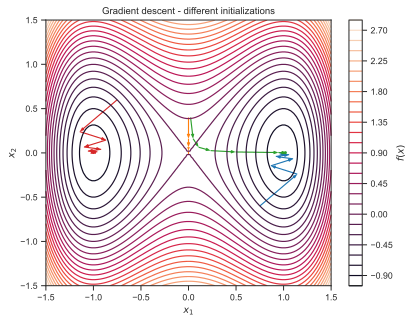

In [14]:
# The function to minimize
f = lambda x: x[0] ** 4 - 2.0 * x[0] ** 2 + x[1] ** 2
vf = vmap(f)
grad_f = jit(grad(f))

# The minimum
x_star = jnp.array([0.0, 0.0])

# The learning rate
alpha = 0.3

# Plot 2D contour and path of optimization
x1s = jnp.linspace(-1.5, 1.5, 100)
x2s = jnp.linspace(-1.5, 1.5, 100)
X1, X2 = jnp.meshgrid(x1s, x2s)
X = jnp.vstack([X1.ravel(), X2.ravel()]).T
Z = vf(X).reshape(X1.shape)
c = plt.contour(X1, X2, Z, 30)
plt.colorbar(c, label='$f(x)$')

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Gradient descent - different initializations')


# Run gradient descent
import jax.random as jrandom

key = jrandom.PRNGKey(1)

# Some initial points
x0s = jnp.array(
    [
        [-1.5, -1.5], 
        [0.0, 1.0],
        [0.01, 1.0],
        [1.5, 1.5]
    ]
)

for i, x0 in enumerate(x0s):
    key, subkey = jrandom.split(key)
    x_list = armijo_wolfe(f, x0, n_iter=50, lr=alpha, return_path=True)[1]
    x_list = jnp.stack(x_list, axis=0)
    plot_path(i, x_list)

And observe that the algorithm can move much faster at the beginning, but it automatically slows down as it gets closer to the minimum.